In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import pyspark.sql.functions as F
import seaborn as sns
from config import *
from delta import *
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import StandardScaler

def human_format(num, pos):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return "%.2f%s" % (num, ["", "K", "M", "G", "T", "P"][magnitude])

In [2]:
agg_by_institucion_df = DeltaTable.forPath(spark, agg_by_institucion).toDF().toPandas()

24/04/09 21:50:48 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [3]:
numeros_totales_df = (
    agg_by_institucion_df.query('estado=="TODOS"')
    .set_index("institucion")
    .sort_values("salario_mas_gasto")
)

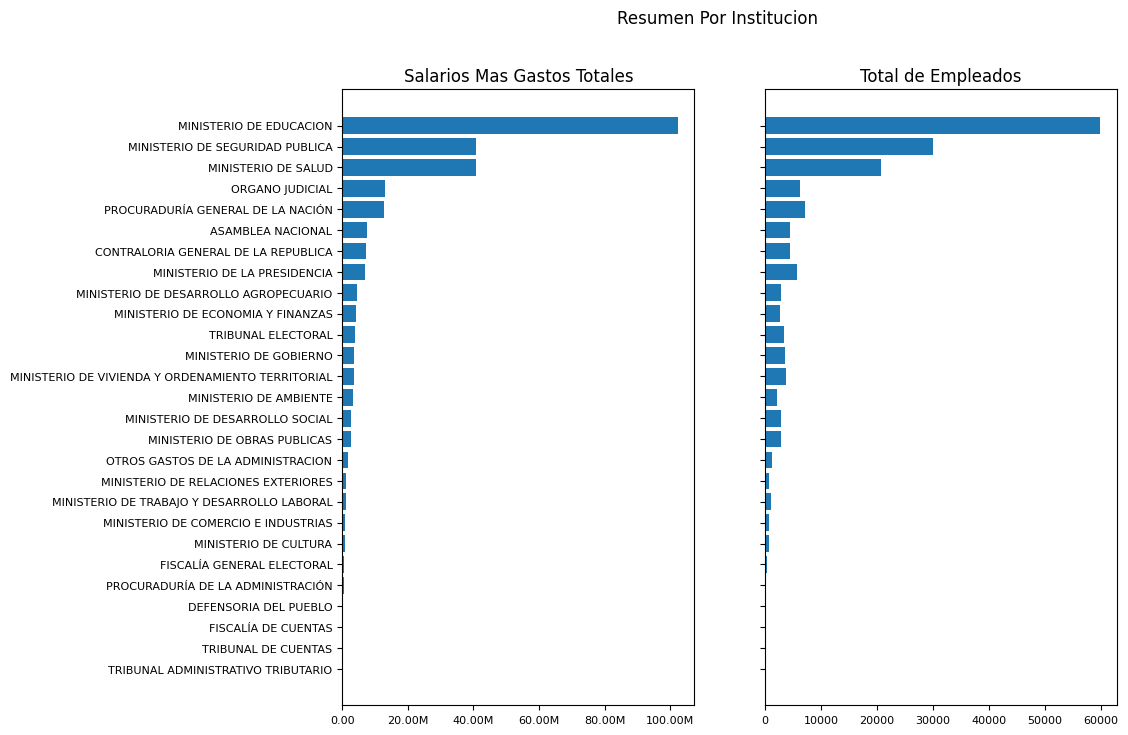

In [4]:
y = numeros_totales_df.index
x1 = numeros_totales_df.salario_mas_gasto
x2 = numeros_totales_df.total_personas

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

fig.set_figwidth(10)
fig.set_figheight(8)

ax1.barh(y, x1)
formatter = FuncFormatter(human_format)
ax1.xaxis.set_major_formatter(formatter)
ax1.tick_params(axis="both", which="major", labelsize=8)
ax1.set_title("Salarios Mas Gastos Totales")

ax2.barh(y, x2)
ax2.set_title("Total de Empleados")
ax2.tick_params(axis="both", which="major", labelsize=8)


fig.suptitle("Resumen Por Institucion", fontsize=12)

plt.show()

In [5]:
reportes_df = (
    DeltaTable.forPath(spark, silver_location)
    .toDF()
    .withColumn(
        "antiguedad", F.datediff(F.current_date(), F.col("fecha_de_inicio")) / 365
    )
    .withColumn("salario_mas_gasto", F.col("salario") + F.col("gasto"))
    .toPandas()
    
)
reportes_df.head(3)

nombre apellido         cedula      cargo  salario  gasto      estado  \
0    DAVIS  WALLACE  8-0821-002152  ABOGADO I   2500.0    0.0    EVENTUAL   
1  DIXIANA  GARRIDO  8-0750-001016  ABOGADO I   1800.0    0.0    EVENTUAL   
2   EMILIA   MADURO  8-0807-000628  ABOGADO I   1500.0    0.0  PERMANENTE   

  fecha_de_inicio fecha_actualizacion      fecha_consulta  \
0      2024-02-01 2024-04-02 08:20:09 2024-04-09 19:38:40   
1      2024-02-01 2024-04-02 08:20:09 2024-04-09 19:38:40   
2      2022-03-02 2024-04-02 08:20:09 2024-04-09 19:38:40   

                                      nombre_reporte              institucion  \
0  file:///home/hadoop/deltalake/contraloria/plan...  MINISTERIO DE EDUCACION   
1  file:///home/hadoop/deltalake/contraloria/plan...  MINISTERIO DE EDUCACION   
2  file:///home/hadoop/deltalake/contraloria/plan...  MINISTERIO DE EDUCACION   

   antiguedad  salario_mas_gasto  
0    0.186301             2500.0  
1    0.186301             1800.0  
2    2.106849             1500.0

Text(0.5, 1.0, 'Salarios Mas Gastos Totales')

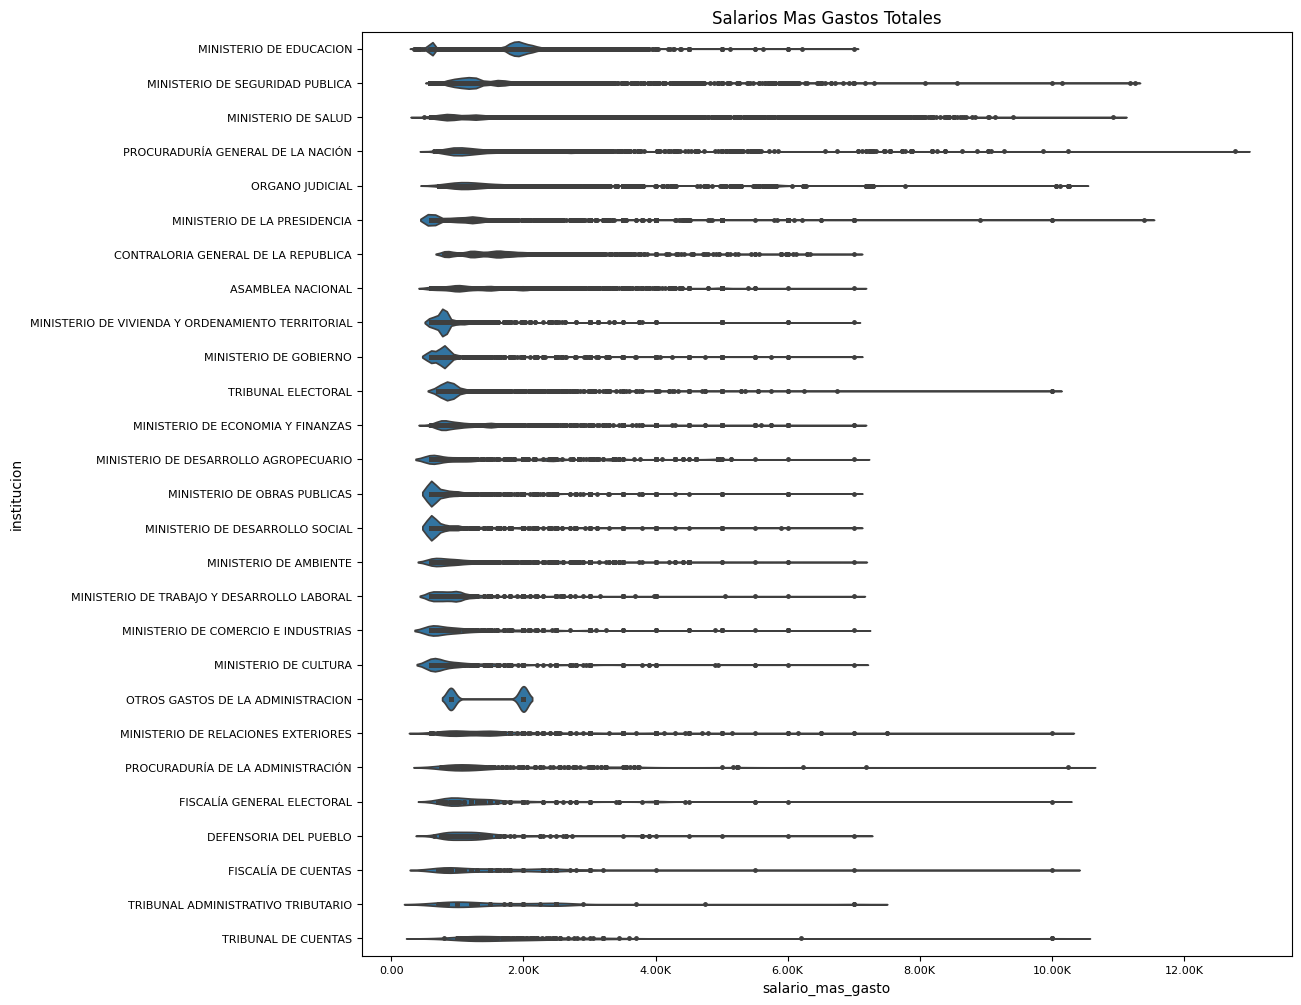

In [6]:
plt.figure(figsize=(12, 12))
fig = sns.violinplot(
    data=reportes_df,
    x="salario_mas_gasto",
    y="institucion",
    bw_adjust=0.5,
    inner="point",
)
formatter = FuncFormatter(human_format)
fig.xaxis.set_major_formatter(formatter)
fig.tick_params(axis="both", which="major", labelsize=8)
fig.set_title("Salarios Mas Gastos Totales")

In [7]:
estadistica_salarios_mas_gasto_por_insitucion = (
    reportes_df.groupby("institucion")
    .salario_mas_gasto.describe()
    .sort_values("mean", ascending=False)
    .applymap(lambda x: "{:.0f}".format(x))
)

estadistica_salarios_mas_gasto_por_insitucion.columns = [
    "Cantidad De Empleados",
    "Promedio",
    "Desviacion Estandar",
    "Minimo",
    "P25",
    "Media",
    "P75",
    "Maximo",
]

estadistica_salarios_mas_gasto_por_insitucion.drop("P25", axis=1).drop(
    "P75", axis=1
).reset_index().style.set_caption(
    "Estadistica Salarios Mas Gastos por Institucion\t(Ordenado Por Salario Promedio)"
).set_table_styles(
    [
        dict(
            selector="caption",
            props=[("text-align", "center"), ("font-size", "150%"), ("color", "black")],
        )
    ]
)

In [9]:

key_columns = [
    "nombre",
    "apellido",
    "cedula",
    "salario",
    "gasto",
    "estado",
    "fecha_de_inicio",
    'fecha_actualizacion',
    "institucion",
    "cargo",
]


def deduplicate_bronze(bronze_table, key_columns=key_columns):
    return (
        bronze_table
        .orderBy(F.col("fecha_consulta"), ascending=False)
        .dropDuplicates(subset=key_columns)
    )

In [11]:

sdf = DeltaTable.forName(spark,bronze_table).toDF()
deduped_sdf = sdf.orderBy(F.col("fecha_consulta"), ascending=False)\
        .dropDuplicates(subset=key_columns)
        


24/04/09 21:51:52 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/04/09 21:51:52 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
24/04/09 21:51:53 ERROR Schema: Failed initialising database.
Unable to open a test connection to the given database. JDBC url = jdbc:derby:;databaseName=metastore_db;create=true, username = APP. Terminating connection pool (set lazyInit to true if you expect to start your database after your app). Original Exception: ------
java.sql.SQLException: Failed to start database 'metastore_db' with class loader jdk.internal.loader.ClassLoaders$AppClassLoader@5ffd2b27, see the next exception for details.
	at org.apache.derby.impl.jdbc.SQLExceptionFactory.getSQLException(Unknown Source)
	at org.apache.derby.impl.jdbc.SQLExceptionFactory.getSQLException(Unknown Source)
	at org.apache.derby.impl.jdbc.Util.seeNextException(Unknown Source)
	at org.apache.derby.impl.jdbc.EmbedConnection.bootDatabase(Unknown Source)
	at org.a

AnalysisException: org.apache.hadoop.hive.ql.metadata.HiveException: java.lang.RuntimeException: Unable to instantiate org.apache.hadoop.hive.ql.metadata.SessionHiveMetaStoreClient